# **演習Ⅰ 課題1**

コードを実行してください。

※上部にある「ドライブにコピー」で自分のドライブにコピーしてから編集・実行してください。

In [1]:
# ライブラリのインポート
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
import torchvision.models as models

# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 各種設定
BATCH_SIZE = 50 # バッチサイズ
MAX_EPOCH = 5   # エポック数
IMAGE_SIZE = 224

# シード値の固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# 自作のデータセットの処理
class MyDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None, target_transform=None, loader=default_loader):
    self.df = pd.read_csv(csv_file)
    self.root_dir = root_dir  # 画像が入っているフォルダ
    self.loader = loader
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.df)

  # dataloaderで読み込むときの処理
  def __getitem__(self, idx):
    # filenameを取得
    file_name = self.df.iloc[idx, 0]
    # 画像のパスを設定（画像が入っているフォルダ / filename）
    img_path = os.path.join(self.root_dir, file_name)
    # 画像を読み込む
    image = self.loader(img_path)

    # labelを取得
    label = self.df.iloc[idx, 1]

    if self.transform is not None:
        image = self.transform(image)
    if self.target_transform is not None:
        label = self.target_transform(label)

    return image, label, img_path

In [4]:
# データの前処理の方法を定義
transform = transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # 画像のサイズを統一
	transforms.ToTensor(),                       # データをテンソルに変換
	transforms.Normalize(mean=[0.5, 0.5, 0.5],
	                     std=[0.5, 0.5, 0.5])
])

In [5]:
# 訓練データ、検証データ、テストデータの準備

# 訓練データの取得
train_dataset = MyDataset(
	csv_file="/content/drive/MyDrive/jts2024_3/data/train.csv", # csvファイルのパス
	root_dir="/content/drive/MyDrive/jts2024_3/data/all/", # 画像が入っているフォルダ
	transform=transform, # データに前処理を適用
)

# 訓練データの一部を検証データとして分割
num_train = len(train_dataset) # 訓練データのデータ数を取得
train_dataset, valid_dataset = torch.utils.data.random_split(
	  train_dataset,
	  [int(num_train * 0.8), int(num_train * 0.2)] # 訓練データの20%を検証データに分割
)

# テストデータの取得
test_dataset = MyDataset(
	csv_file="/content/drive/MyDrive/jts2024_3/data/test.csv", # csvファイルのパス
	root_dir="/content/drive/MyDrive/jts2024_3/data/all/", # 画像が入っているフォルダ
	transform=transform, # データに前処理を適用
)

In [6]:
# データローダーの作成
# データセットからバッチを作成してモデルに供給する役割

# 訓練データ用のデータローダー
train_loader = torch.utils.data.DataLoader(
	train_dataset,
	batch_size=BATCH_SIZE, # バッチサイズごとにデータを供給
	shuffle=True,          # 学習時はデータをシャッフル
)
# 検証データ用のデータローダー
valid_loader = torch.utils.data.DataLoader(
	valid_dataset,
	batch_size=BATCH_SIZE, # バッチサイズごとにデータを供給
	shuffle=False,         # 検証時はシャッフルしない
)
# テストデータ用のデータローダー
test_loader = torch.utils.data.DataLoader(
	test_dataset,
	batch_size=BATCH_SIZE, # バッチサイズごとにデータを供給
	shuffle=False,         # テスト時もシャッフルしない
)

In [7]:
# ResNetのインスタンス化
model = models.resnet18()

model.fc = nn.Linear(512, 2)

# 損失関数の定義
loss_function = nn.CrossEntropyLoss()

# 最適化手法と学習率の定義
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
# 学習を通しての損失を記録するためのリスト（学習曲線のプロット用）
train_losses = []
valid_losses = []

# 学習にかかった時間の計測開始
start_time = time.time()

print("\n【学習開始】\n")
print("train_loss: 学習データにおける損失")
print("valid_loss: 検証データにおける損失\n")

# エポックごとの訓練損失と検証損失を出力
print("epoch\ttrain_loss\tvalid_loss")

for epoch in range(MAX_EPOCH):
	model.train()        # モデルを訓練モードに設定
	train_loss_list = [] # 訓練損失を保存するリスト

	# 訓練データでモデルを学習
	for x, label, img_path in train_loader:
		optimizer.zero_grad()               # 勾配をリセット
		output = model(x)                   # モデルの出力を計算
		loss = loss_function(output, label) # 損失を計算
		loss.backward()                     # 勾配を計算
		optimizer.step()                    # 勾配に基づいてパラメータを更新
		train_loss_list.append(loss.item()) # バッチごとの損失を記録

	train_loss_mean = np.mean(train_loss_list) # エポックごとの平均訓練損失
	train_losses.append(train_loss_mean)       # 訓練損失をリストに追加

	model.eval()         # モデルを評価モードに設定
	valid_loss_list = [] # 検証損失を保存するリスト

	# 検証データで損失を計算
	for x, label, img_path in valid_loader:
		output = model(x)                      # モデルの出力を計算
		loss = loss_function(output, label)    # 損失を計算
		valid_loss_list.append(loss.item())    # バッチごとの損失を記録

	valid_loss_mean = np.mean(valid_loss_list) # エポックごとの平均検証損失
	valid_losses.append(valid_loss_mean)       # 検証損失をリストに追加

	print("{}\t{:.8}\t{:.8}".format(epoch, train_loss_mean, valid_loss_mean))

# 学習にかかった時間の計測終了
end_time = time.time()
print("\n学習にかかった時間 : {} [sec]".format(end_time - start_time))

print("\n【学習終了】\n")


【学習開始】

train_loss: 学習データにおける損失
valid_loss: 検証データにおける損失

epoch	train_loss	valid_loss
0	0.65621567	0.70217872
1	0.48168993	1.0252495
2	0.27840966	0.72271438
3	0.089093189	1.0175219
4	0.032203702	1.4863765

学習にかかった時間 : 850.5684900283813 [sec]

【学習終了】



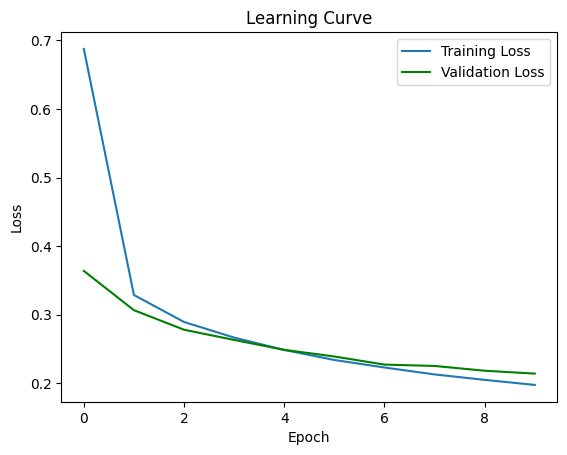

In [ ]:
# 学習曲線のプロット
plt.plot(range(MAX_EPOCH), train_losses, label='Training Loss')
plt.plot(range(MAX_EPOCH), valid_losses, label='Validation Loss', color="green")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [ ]:
# テストデータを使ってモデルを評価
model.eval() # モデルを評価モードに設定
test_loss = 0
test_correct = 0
test_total = 0

# テストデータでの損失と正解率を計算
for x, label, img_path in test_loader:
	output = model(x)                            # モデルの出力を計算
	loss = loss_function(output, label)          # 損失を計算
	_, pred = torch.max(output.data, dim=1)      # 出力の最大値を持つクラスを予測
	test_correct += (pred == label).sum().item() # 正解の数をカウント
	test_total += label.size()[0]                # テストデータの総数をカウント

# テストデータにおける正解率を計算して表示
test_accuracy = test_correct / test_total
print("テストデータにおける正解率 : {:.4f}".format(test_accuracy))

テストデータにおける正解率 : 0.9408


In [ ]:
# モデルの保存
model_dir = "/content/drive/MyDrive/jts2024_3/model/"
os.makedirs(model_dir, exist_ok=True)
for i in range(10):
  save_path = f"{model_dir}resnet{i}.pt"
  if not os.path.exists(save_path):
    torch.save(model.state_dict(), save_path)
    break